In [1]:
from skimage.feature import graycomatrix, graycoprops
from helper import *
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import os, sys
import numpy as np
import cv2

In [2]:
def get_lbp_hist(grayscale_img):
    hist = np.zeros(256)
    for i in range (1, grayscale_img.shape[0] - 1):
        for j in range (1, grayscale_img.shape[1] - 1):
            b = 0b00000000
            if(grayscale_img[i - 1][j- 1] > grayscale_img[i][j]):
                b = b | 0b10000000
            if(grayscale_img[i - 1][j] > grayscale_img[i][j]):
                b = b | 0b01000000
            if(grayscale_img[i - 1][j+ 1] > grayscale_img[i][j]):
                b = b | 0b00100000
            if(grayscale_img[i][j + 1] > grayscale_img[i][j]):
                b = b | 0b00010000
            if(grayscale_img[i + 1][j + 1] > grayscale_img[i][j]):
                b = b | 0b00001000
            if(grayscale_img[i + 1][j] > grayscale_img[i][j]):
                b = b | 0b00000100
            if(grayscale_img[i + 1][j- 1] > grayscale_img[i][j]):
                b = b | 0b00000010
            if(grayscale_img[i][j- 1] > grayscale_img[i][j]):
                b = b | 0b00000001
            hist[b] = hist[b] + 1
    return hist

In [3]:
def train_lbph(images):
    noOfPersons = images.shape[0]
    hist = []  
    for k in range(noOfPersons):
        for face in images[k]:
            face_resize = cv2.resize(face, (256, 256))  
            hist_lbp = get_lbp_hist(face_resize)  
            hist.append(hist_lbp)
    return hist 

In [4]:
def predict_lbph(input_image,recognizer,residentsNames):
    d1=recognizer.shape[0]
    input_hist = get_lbp_hist(cv2.resize(input_image, (256, 256)))
    distance = 0
    thresh = 2000000
    index = 0
    eps = 1e-10
    for i in range(d1):
        distance = 0.005 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(recognizer[i,:], input_hist)])
        if distance<thresh:
            index=i
            thresh=distance
    return (residentsNames[index],thresh)

In [5]:
def extract_faces_residentName(gray):
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades +  "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.35,
        minNeighbors=8,
        minSize=(60, 60)
    )
    face_images=[]
    for (x, y, w, h) in faces:
        cv2.rectangle(gray, (x, y-15), (x+w, y+h), (0, 255, 0), 2)
        roi_color = gray[y-15:y + h, x:x + w]
        
        face_images.append(roi_color)
    return face_images

In [6]:
def training_lbph_residentName():
    (images, residentsNames, names, id) = ([], [], {}, 0)
    for (subdirs, dirs, files) in os.walk('../TrainingImages'):
        for subdir in dirs:
            names[id] = subdir
            subjectpath = os.path.join('../TrainingImages', subdir)
            print(subdir)
            print(subjectpath)
            num=0
            for filename in os.listdir(subjectpath):
                path = subjectpath + '/' + filename
                lable = subdir
                images.append(cv2.imread(path, 0))
                residentsNames.append(lable)
                num+=1

            id += 1
    (im_width, im_height) = (68, 68)
    (images_arr, residentsNames_arr) = [np.array(lis) for lis in [images, residentsNames]]
    s1 = images_arr.shape[0]
    total_faces=[]
    for i in range(s1):
        faces = extract_faces_residentName(images_arr[i])   
        total_faces.append(faces)
    (faces_arr, residentsNames_arr) = [np.array(lis) for lis in [total_faces, residentsNames]]
    trained_face_recognizer=train_lbph(faces_arr) 
    print('finished training')
    np.save('trained.npy',trained_face_recognizer)

    return residentsNames


In [7]:
residentsNames=training_lbph_residentName()

benzema
../TrainingImages\benzema
cr7
../TrainingImages\cr7
ElonMusk
../TrainingImages\ElonMusk
mbappe
../TrainingImages\mbappe
mo salah
../TrainingImages\mo salah


C:\Users\Rufai\AppData\Local\Temp\ipykernel_23764\2602629348.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (images_arr, residentsNames_arr) = [np.array(lis) for lis in [images, residentsNames]]
C:\Users\Rufai\AppData\Local\Temp\ipykernel_23764\2602629348.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (faces_arr, residentsNames_arr) = [np.array(lis) for lis in [total_faces, residentsNames]]


finished training


In [8]:
def test(imgfile):
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    trained_face_recognizer=np.load('trained.npy')
    np.load = np_load_old
    myimage=io.imread('../TestImages/'+imgfile)
    gray = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
    faces=extract_faces_residentName(gray)

    for face in faces:
        show_images([face])
        prediction=predict_lbph(face,trained_face_recognizer,residentsNames)
        if (prediction[1])<200:
            print("Hello " + prediction[0] + ", going to the target floor now :)")
        else:
            print("Probably, you are a visitor. Welcome to our building :)")
    print(prediction)



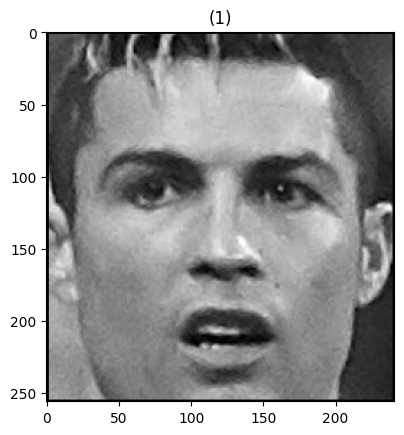

Hello ElonMusk, going to the target floor now :)


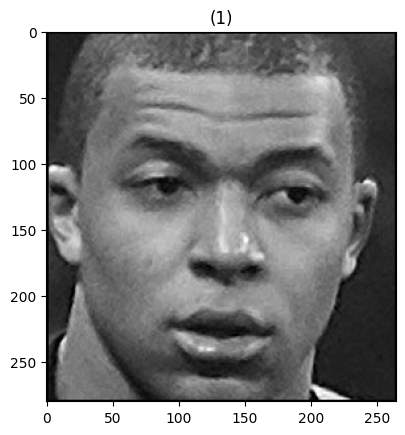

Hello ElonMusk, going to the target floor now :)
('ElonMusk', 10.049574654278937)


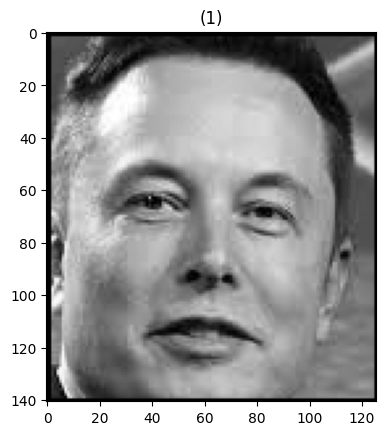

Hello benzema, going to the target floor now :)
('benzema', 3.6104324304738835)


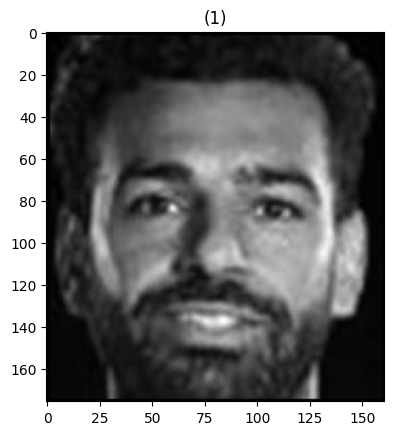

Hello cr7, going to the target floor now :)
('cr7', 7.177680502370731)


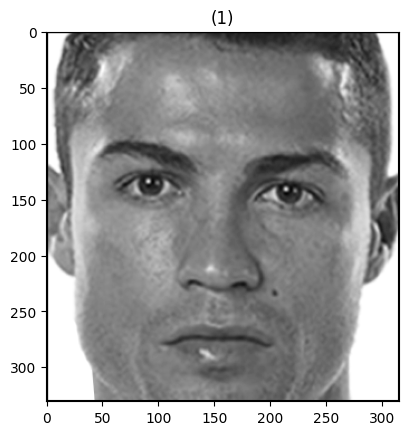

Hello cr7, going to the target floor now :)
('cr7', 7.093407684587582)


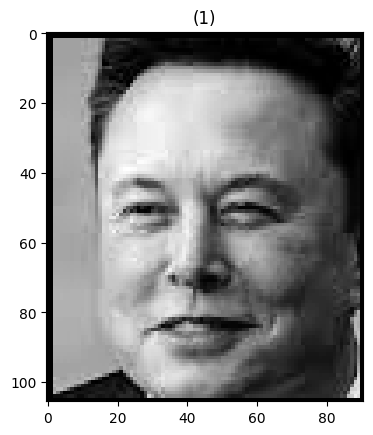

Hello ElonMusk, going to the target floor now :)
('ElonMusk', 7.995359813988541)


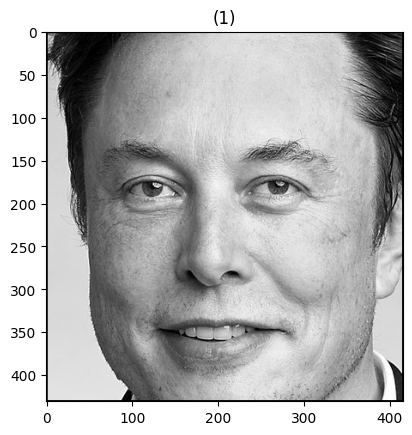

Hello benzema, going to the target floor now :)
('benzema', 6.625294474390487)


In [18]:
test('mbappe_ronaldo.jpg')
test('elon2.jpeg')
test('salaah_2.jpg')
test('ronaldo.png')
test('elon.jpeg')
test('Elon_Musk.jpg')